In [1]:
from IPython.display import clear_output
from collections import deque, namedtuple
import numpy as np
import torch
import random
import math
import matplotlib.pyplot as plt
%matplotlib inline

from gdai import Circuit, Designer
from gdai_utils import make_dataIn, softmax, set_data_sel, record_ep, decrease_epsilon
from gdai_utils import rec_Bufs, make_replayBuf, record_ep, plot_result
from cir2netlist import Cir2Netlist

gpu = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(gpu)

cuda


In [2]:
# Truth Table
data1 = deque((([-1,0],1), ([-1,0],1), ([1,0],-1), ([1,0],-1))) # Inverter
data2 = deque((([0,-1],1), ([0,-1],1), ([0,1],-1), ([0,1],-1))) # Inverter
data3 = deque((([-1,-1],1), ([-1,1],1), ([1,-1],1), ([1,1],-1))) # NAND
data4 = deque((([-1,-1],1), ([-1,1],-1), ([1,-1],-1), ([1,1],-1))) # NOR
data5 = deque((([-1,0],-1), ([-1,0],-1), ([1,0],1), ([1,0],1))) # Buffer
data6 = deque((([0,-1],-1), ([0,-1],-1), ([0,1],1), ([0,1],1))) # Buffer
data7 = deque((([-1,-1],-1), ([-1,1],-1), ([1,-1],-1), ([1,1],1))) # AND
data8 = deque((([-1,-1],-1), ([-1,1],1), ([1,-1],1), ([1,1],1))) # OR
datas = [data1, data2, data3, data4, data5, data6, data7, data8]

dataIn1 = make_dataIn(data1); dataIn2 = make_dataIn(data2)
dataIn3 = make_dataIn(data3); dataIn4 = make_dataIn(data4)
dataIn5 = make_dataIn(data5); dataIn6 = make_dataIn(data6)
dataIn7 = make_dataIn(data7); dataIn8 = make_dataIn(data8)
dataIns = [dataIn1, dataIn2, dataIn3, dataIn4, dataIn5, dataIn6, dataIn7, dataIn8]

sim     = 0; sim_plot = []
sc_plot_tr = [[], [], [], [], [], [], [], []]; sc_plot_ts = [[], [], [], [], [], [], [], []]
num_sim_tr = [0, 0, 0, 0, 0, 0, 0, 0]; num_sim_ts = [0, 0, 0, 0, 0, 0, 0, 0]
sc_sim_tr = [0, 0, 0, 0, 0, 0, 0, 0]; sc_sim_ts = [0, 0, 0, 0, 0, 0, 0, 0]
sc_acc_tr = [0, 0, 0, 0, 0, 0, 0, 0]; sc_acc_ts = [0, 0, 0, 0, 0, 0, 0, 0]
moving = [[], [], [], [], [], [], [], []]

q_stat = [[], []]
q_mean = []
q_std = []
# g_stat = [[], []]


# Bufs = [s1Buf, s2Buf, s3Buf, s4Buf, s5Buf, s6Buf, s7Buf, s8Buf, fBuf]
Bufs    = [deque(maxlen = 1024), deque(maxlen = 1024), deque(maxlen = 1024),
           deque(maxlen = 1024), deque(maxlen = 1024), deque(maxlen = 1024),
           deque(maxlen = 1024), deque(maxlen = 1024), deque(maxlen = 1024)]

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
    def push(self, *args):
        self.memory.append(Transition(*args))
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def __len__(self):
        return len(self.memory)
memory = ReplayMemory(1000000)

l_rate = 0.001

# class object
cir  = Circuit(numIn=2, numOut=1, numN=2, numP=2, data = data1, gpu = gpu)
gdai = Designer(l_rate, cir.frontSize, cir.spaSize, cir.chSize, gpu=gpu)
net = Cir2Netlist(numIn=2, numOut=1, numN=2, numP=2)

criterion = torch.nn.MSELoss()

In [3]:
# Hyperparameters
num_episode = 64
epsilon = 0.99
gamma = 0.95

batch_size = 128
target_update = 10000

sim: 9999
========== TRAIN ==========
<This sim>
INV1: 0/7 INV2: 0/6 NAND: 0/12 NOR: 0/11
BUF1: 0/1 BUF2: 13/13 AND: 0/8 OR: 2/6
<Accumulated Success>
INV1: 88 INV2: 49 NAND: 0 NOR: 3
BUF1: 20569 BUF2: 27492 AND: 7070 OR: 4289


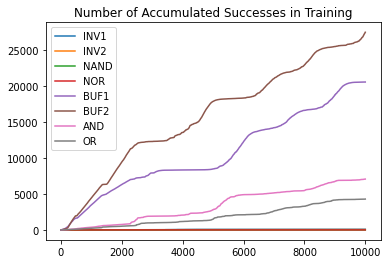

========== TEST ==========
<This sim>
INV1: 0/1 INV2: 0/1 NAND: 0/1 NOR: 0/1
BUF1: 0/1 BUF2: 1/1 AND: 0/1 OR: 1/1
<Accumulated Success>
INV1: 8 INV2: 6 NAND: 0 NOR: 0
BUF1: 5496 BUF2: 5198 AND: 828 OR: 486


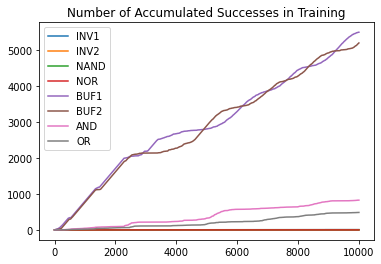

<moving success rate>


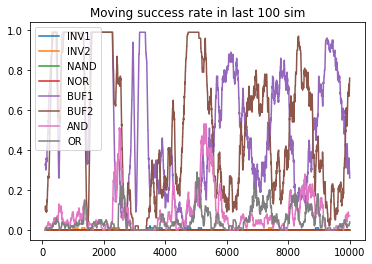

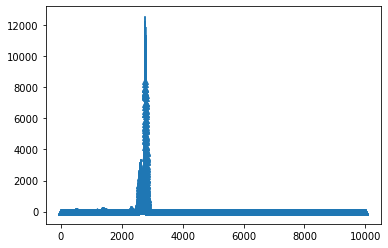

In [4]:
while sim < target_update:
    # target update
    gdai.update()
    
    gdai.mainDQ.train()
    # episode, put in memory
    for ep in range(num_episode):
        cir.reset()
        done, turn = 0, 0
        scRatio = (1-softmax(sc_acc_ts))/7
        sel = np.random.choice(8,p=scRatio)
        data = set_data_sel(sel, cir, datas, dataIns)
        while not done:
            turn += 1
            state = torch.Tensor(np.concatenate((cir.inputGen(),data))).to(gpu)
            mask = torch.Tensor(cir.maskGen(data)[0]).to(gpu)
            num, Q = gdai.design(epsilon, state, mask)
            reward, done = cir.step(num)
            
            if not done:
                next_state = torch.Tensor(np.concatenate((cir.inputGen(),data))).to(gpu)
            else: # if done
                next_state = None

            memory.push(state, num, next_state, reward)

        num_sim_tr, sc_sim_tr = record_ep(reward, sel, num_sim_tr, sc_sim_tr)

        # TRAIN (Optimize)
        if len(memory) > batch_size:
            transitions = memory.sample(batch_size)
            batch = Transition(*zip(*transitions))

            non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=gpu, dtype=torch.bool)
            # if non_final transition(next_state != None): True
            # if final transition (next_state == None): False
            non_final_next_states = torch.stack([s for s in batch.next_state if s is not None])

            state_batch = torch.stack(batch.state)
            action_batch = torch.stack(batch.action)
            reward_batch = torch.cat(batch.reward)

            # Q(s_t, a_t)
            state_action_values = gdai.mainDQ(state_batch).gather(1, action_batch)

            next_state_values = torch.zeros(batch_size, device=gpu)
            next_state_values[non_final_mask] = gdai.targetDQ(non_final_next_states).max(1)[0].detach()
 
            # (reward + gamma * max_a{Q(s',a)})
            expected_state_action_values = (next_state_values * gamma) + reward_batch

            loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

            gdai.opt_mainDQ.zero_grad()
            loss.backward()
            gdai.opt_mainDQ.step()


    gdai.mainDQ.eval()
    # TEST
    for se in range(8):
        cir.reset()
        data = set_data_sel(se, cir, datas, dataIns)
        done, turn = 0, 0
        q_store = []
        while not done:
            turn += 1
            state = torch.Tensor(np.concatenate ((cir.inputGen(),data))).to(gpu)
            mask = torch.Tensor(cir.maskGen(data)[0]).to(gpu)
            num, Q = gdai.design(0.1, state, mask, learn=False)
            reward, done = cir.step(num)
            q_store.append(Q.cpu().detach().numpy())
        num_sim_ts, sc_sim_ts = record_ep(reward, se, num_sim_ts, sc_sim_ts)

    mean_ = (sum(q_store)/len(q_store))
    var_ = sum((l-mean_)**2 for l in q_store) / len(q_store)

    mean_store = mean_.mean()
    var_store = var_.mean()
    st_dev = math.sqrt(var_store)
    # stat_temp = [mean_store, st_dev]
    q_mean.append(mean_store)
    q_std.append(st_dev)
    # print(q_stat)

    # PLOT and INIT
    clear_output()
    sim_plot, sc_plot_tr, sc_acc_tr, moving = plot_result(True, sim, sim_plot, sc_plot_tr, num_sim_tr, sc_sim_tr, sc_acc_tr, moving)
    sim_plot, sc_plot_ts, sc_acc_ts, moving = plot_result(False, sim, sim_plot, sc_plot_ts, num_sim_ts, sc_sim_ts, sc_acc_ts, moving)
    num_sim_tr = [0, 0, 0, 0, 0, 0, 0, 0]; num_sim_ts = [0, 0, 0, 0, 0, 0, 0, 0]
    sc_sim_tr = [0, 0, 0, 0, 0, 0, 0, 0]; sc_sim_ts = [0, 0, 0, 0, 0, 0, 0, 0]
    epsilon = decrease_epsilon(epsilon, sim, 100)

    plt.errorbar(sim_plot, q_mean, q_std, marker = '^')
    plt.show()



    ##########################
    sim += 1